<a href="https://colab.research.google.com/github/oleksandr-g-rock/How_to_create-image-classification-for-recognizing-persons-animals-others/blob/main/animal_person_other_v2_final_version.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Notebook for predict:
# person, animals (dog, squirrel, horse, chicken, cats, raccoon, deer),other.
# used MobileNetV2 model

connect to GD

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Need download Dataset

In [ ]:
!cp drive/My\ Drive/animals_and_person.zip /content/
!wget https://raw.githubusercontent.com/oleksandr-g-rock/How_to_create-image-classification-for-recognizing-persons-animals-others/main/animal_person_other_sort.sh

Need unzip folder

In [ ]:
!jar xvf /content/animals_and_person.zip


sorted all files to train and test

RENAME MAIN FOLDER

In [ ]:
!mv /content/animals_and_person /content/animals_and_person

In [ ]:
!cat /content/animal_person_other_sort.sh
!bash /content/animal_person_other_sort.sh

Convert full data to jpg and after that remove all png 

In [ ]:
!apt-get install parallel 
!apt-get install imagemagick
!apt -y update


In [ ]:
!chmod -R 777 /content/animals_and_person/

!ls /content/animals_and_person/train/ | while read -r NAME; do ls /content/animals_and_person/train/$NAME/*.png | parallel convert '{}' '{.}.jpg' || true ; done

!ls /content/animals_and_person/val/ | while read -r NAME; do ls /content/animals_and_person/val/$NAME/*.png | parallel convert '{}' '{.}.jpg' || true ; done


In [ ]:
!ls -la /content/animals_and_person/train/other

In [ ]:
!find /content/animals_and_person -name '*.png' -exec rm -f {} +

add testing folder and move 10 files from val from each class

In [ ]:
!mkdir /content/animals_and_person/testing
!cp -r /content/animals_and_person/train/* /content/animals_and_person/testing/

In [ ]:
!ls /content/animals_and_person/testing/ | while read -r NAME; do cd /content/animals_and_person/testing/"${NAME}" && rm -rf * ; done

In [ ]:
!ls /content/animals_and_person/val/ | while read -r NAME; do cd /content/animals_and_person/val/"${NAME}" && ls | tail -100 | xargs -I{} sudo mv {} /content/animals_and_person/testing/"${NAME}"/ ; done

**START PREPARE AND RUN TRAIN OUR MODEL**

Download modules

In [ ]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.layers import BatchNormalization, Activation
from tensorflow.python.keras.optimizers import Adam, RMSprop
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from numpy import loadtxt
import tensorflow.keras
from PIL import Image, ImageOps
%matplotlib inline

Set image size & batch size

In [ ]:
image_size = 299
batch_size = 64

# Create image generator

In [ ]:
# folders with train dir & val dir
train_dir = '/content/animals_and_person/train/'
test_dir = '/content/animals_and_person/val/'
testing_dir = '/content/animals_and_person/testing/'
input_shape = (image_size, image_size, 3)

Create image data generator for train data

In [ ]:
train_datagen = ImageDataGenerator(rescale=1. / 255,
                              height_shift_range= 0.02, 
                              width_shift_range=0.02, 
                              rotation_range=0.02, 
                              shear_range = 0.01,
                              fill_mode='nearest',
                              zoom_range=0.01)

Check generator

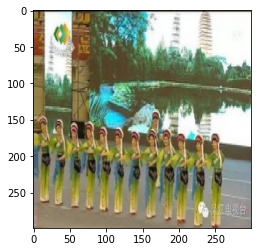

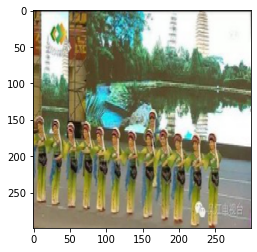

In [ ]:
img_path = '/content/animals_and_person/testing/person/012414.jpg'
img = image.load_img(img_path, target_size=(image_size, image_size))
x = image.img_to_array(img)
x = x.reshape((1,) + x.shape)
i = 0
for batch in train_datagen.flow(x, batch_size=1):
    plt.figure(i)
    imgplot = plt.imshow(image.array_to_img(batch[0]))
    i += 1
    if i % 2 == 0:
        break
plt.show()

Setting train generator

In [ ]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(image_size, image_size),
    batch_size=batch_size,
    class_mode='categorical')

Found 90486 images belonging to 3 classes.


Setting test generator without data augmentation

In [ ]:
test_datagen = ImageDataGenerator(rescale=1. / 255)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(image_size, image_size),
    batch_size=batch_size,
    class_mode='categorical')

Found 22516 images belonging to 3 classes.


Setting tesing generator without data augmentation

In [ ]:
testing_datagen = ImageDataGenerator(rescale=1. / 255)

testing_generator = testing_datagen.flow_from_directory(
    testing_dir,
    target_size=(image_size, image_size),
    batch_size=batch_size,
    shuffle=False,
    class_mode='categorical')

Found 300 images belonging to 3 classes.


Print count classes

In [ ]:
train_generator.class_indices

{'animals': 0, 'other': 1, 'person': 2}

Graph count images per classes "train"



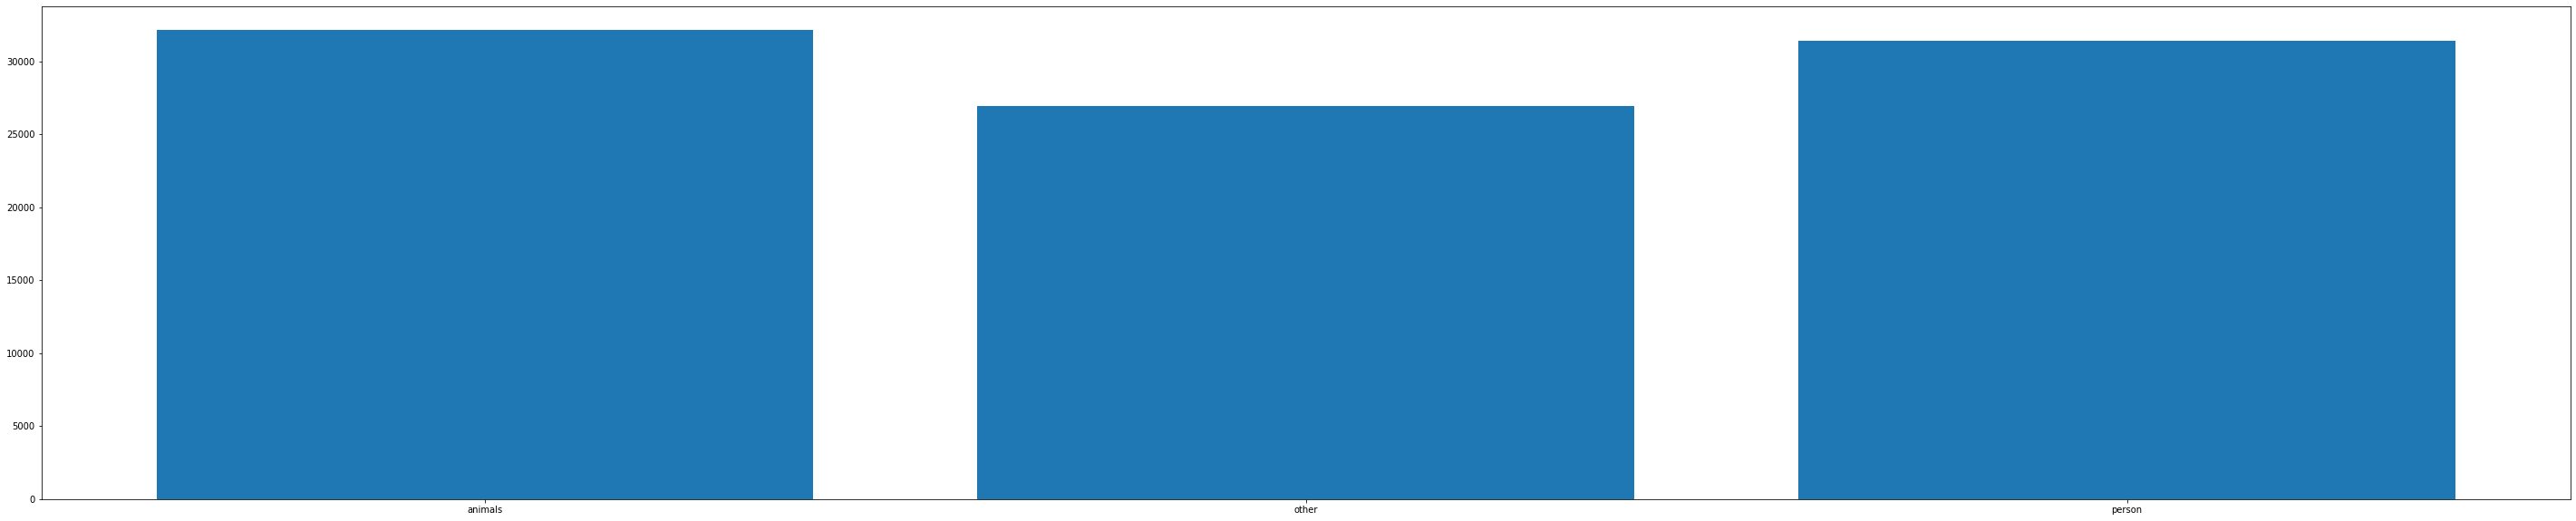

In [ ]:
from sklearn.utils.class_weight import compute_class_weight
cls_train = train_generator.classes
from collections import OrderedDict
classes = list(train_generator.class_indices.keys())
num_values = []
unique, counts = np.unique(cls_train, return_counts=True)
valdict=OrderedDict(zip(unique, counts))
for i in range(3):
    num_values.append(valdict[i])
plt.figure(figsize=(50,10))
x = np.arange(len(num_values))
xlabel = classes
plt.bar(x, num_values)
plt.xticks(x, xlabel)
plt.show()   

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: Non-1D inputs to pie() are currently squeeze()d, but this behavior is deprecated since 3.1 and will be removed in 3.3; pass a 1D array instead.
  


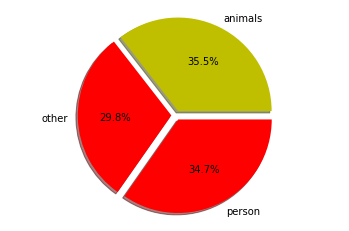

In [ ]:
import matplotlib.pyplot as plt
goal_types = list(train_generator.class_indices.keys())
unique, counts = np.unique(cls_train, return_counts=True)
goals = [(counts)]
colors = ['y','r', 'r']
plt.pie(goals, labels = goal_types, colors=colors ,shadow = True, explode = (0.05, 0.05, 0.05), autopct = '%1.1f%%')
plt.axis('equal')
plt.show()

Graph count images per classes "test"

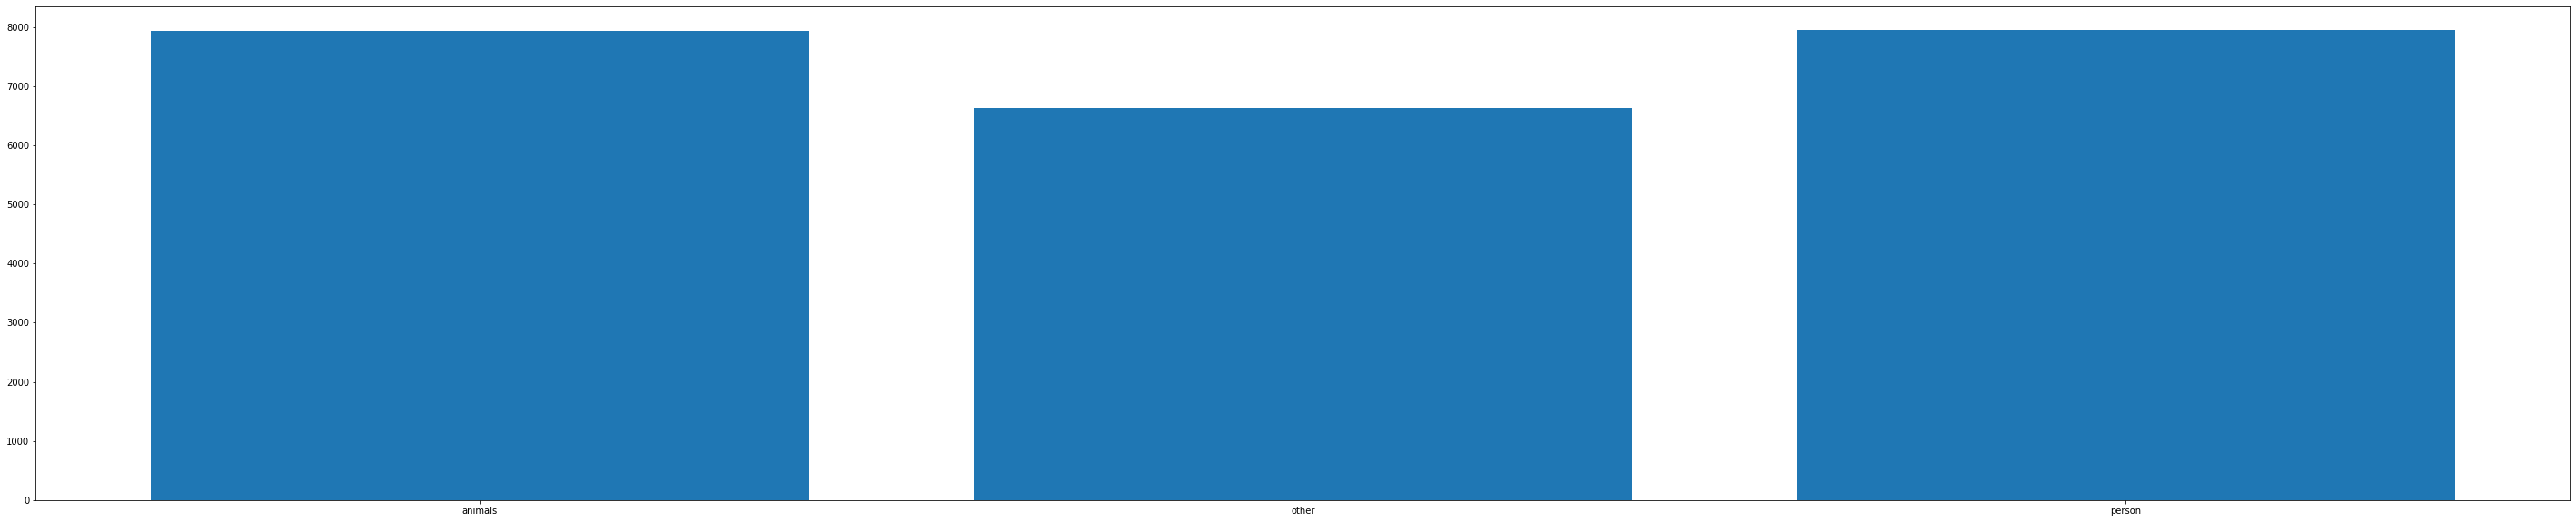

In [ ]:
from sklearn.utils.class_weight import compute_class_weight
cls_test = test_generator.classes
from collections import OrderedDict


classes = list(test_generator.class_indices.keys())
num_values = []
unique, counts = np.unique(cls_test, return_counts=True)
valdict=OrderedDict(zip(unique, counts))
for i in range(3):
    num_values.append(valdict[i])
plt.figure(figsize=(50,10))
x = np.arange(len(num_values))
xlabel = classes
plt.bar(x, num_values)
plt.xticks(x, xlabel)
plt.show() 


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Non-1D inputs to pie() are currently squeeze()d, but this behavior is deprecated since 3.1 and will be removed in 3.3; pass a 1D array instead.
  import sys


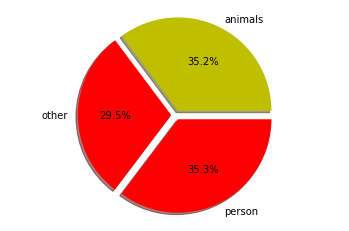

In [ ]:
import matplotlib.pyplot as plt

goal_types = list(test_generator.class_indices.keys())
unique, counts = np.unique(cls_test, return_counts=True)
goals = [(counts)]
colors = ['y','r', 'r']
plt.pie(goals, labels = goal_types, colors=colors ,shadow = True, explode = (0.05, 0.05, 0.05), autopct = '%1.1f%%')
plt.axis('equal')

plt.show()

# Download MobileNetV2 model

In [ ]:
pretrained_model = tf.keras.applications.MobileNetV2(weights='imagenet', include_top=False)
pretrained_model.summary()

"Frozen" all weights pretrained models 

In [ ]:
pretrained_model.trainable = False

# Created main layers for end MobileNetV2 model

In [ ]:
x = pretrained_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(3, activation='softmax')(x)
model = Model(inputs=pretrained_model.input, outputs=predictions)

View all model before training

In [ ]:
model.summary()

# Train a composite neural network based on MobileNetV2 model

In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam', 
              metrics=["accuracy"])

filepath="inceptionv3_best.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min')
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', 
                                            patience=10, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)
callbacks_list = [checkpoint, learning_rate_reduction]

steps_per_epoch = 32
history = model.fit_generator(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    validation_data=test_generator,
    validation_steps=5,
    callbacks=callbacks_list,
    epochs=10,
    verbose=1)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/10
32/32 [==============================] - ETA: 0s - loss: 0.1780 - accuracy: 0.9390
Epoch 00001: val_loss improved from inf to 0.07611, saving model to inceptionv3_best.h5
32/32 [==============================] - 39s 1s/step - loss: 0.1780 - accuracy: 0.9390 - val_loss: 0.0761 - val_accuracy: 0.9781
Epoch 2/10
32/32 [==============================] - ETA: 0s - loss: 0.0306 - accuracy: 0.9907
Epoch 00002: val_loss improved from 0.07611 to 0.00908, saving model to inceptionv3_best.h5
32/32 [==============================] - 39s 1s/step - loss: 0.0306 - accuracy: 0.9907 - val_loss: 0.0091 - val_accuracy: 0.9969
Epoch 3/10
32/32 [==============================] - ETA: 0s - loss: 0.0361 - accuracy: 0.9893
Epoch 00003: val_loss did not improve from 0.00908
32/32 [==============================] - 39s 1s/step - loss: 0.0361 - accuracy: 0.9893 - val_loss: 0.0161 - val_accuracy: 0.9969
Epoch 4/10
32/32 [======

Test Score

In [ ]:
test_score = model.evaluate_generator(testing_generator, batch_size)

print("[INFO] accuracy: {:.2f}%".format(test_score[1] * 100)) 
print("[INFO] Loss: ",test_score[0])

Instructions for updating:
Please use Model.evaluate, which supports generators.
[INFO] accuracy: 99.67%
[INFO] Loss:  0.00737465126439929


Visualize the history of network learning for testing data in confusion matrix format

Instructions for updating:
Please use Model.predict, which supports generators.
Confusion Matrix
Normalized confusion matrix
Classification Report
              precision    recall  f1-score   support

     animals       0.99      1.00      1.00       100
       other       1.00      1.00      1.00       100
      person       1.00      0.99      0.99       100

    accuracy                           1.00       300
   macro avg       1.00      1.00      1.00       300
weighted avg       1.00      1.00      1.00       300



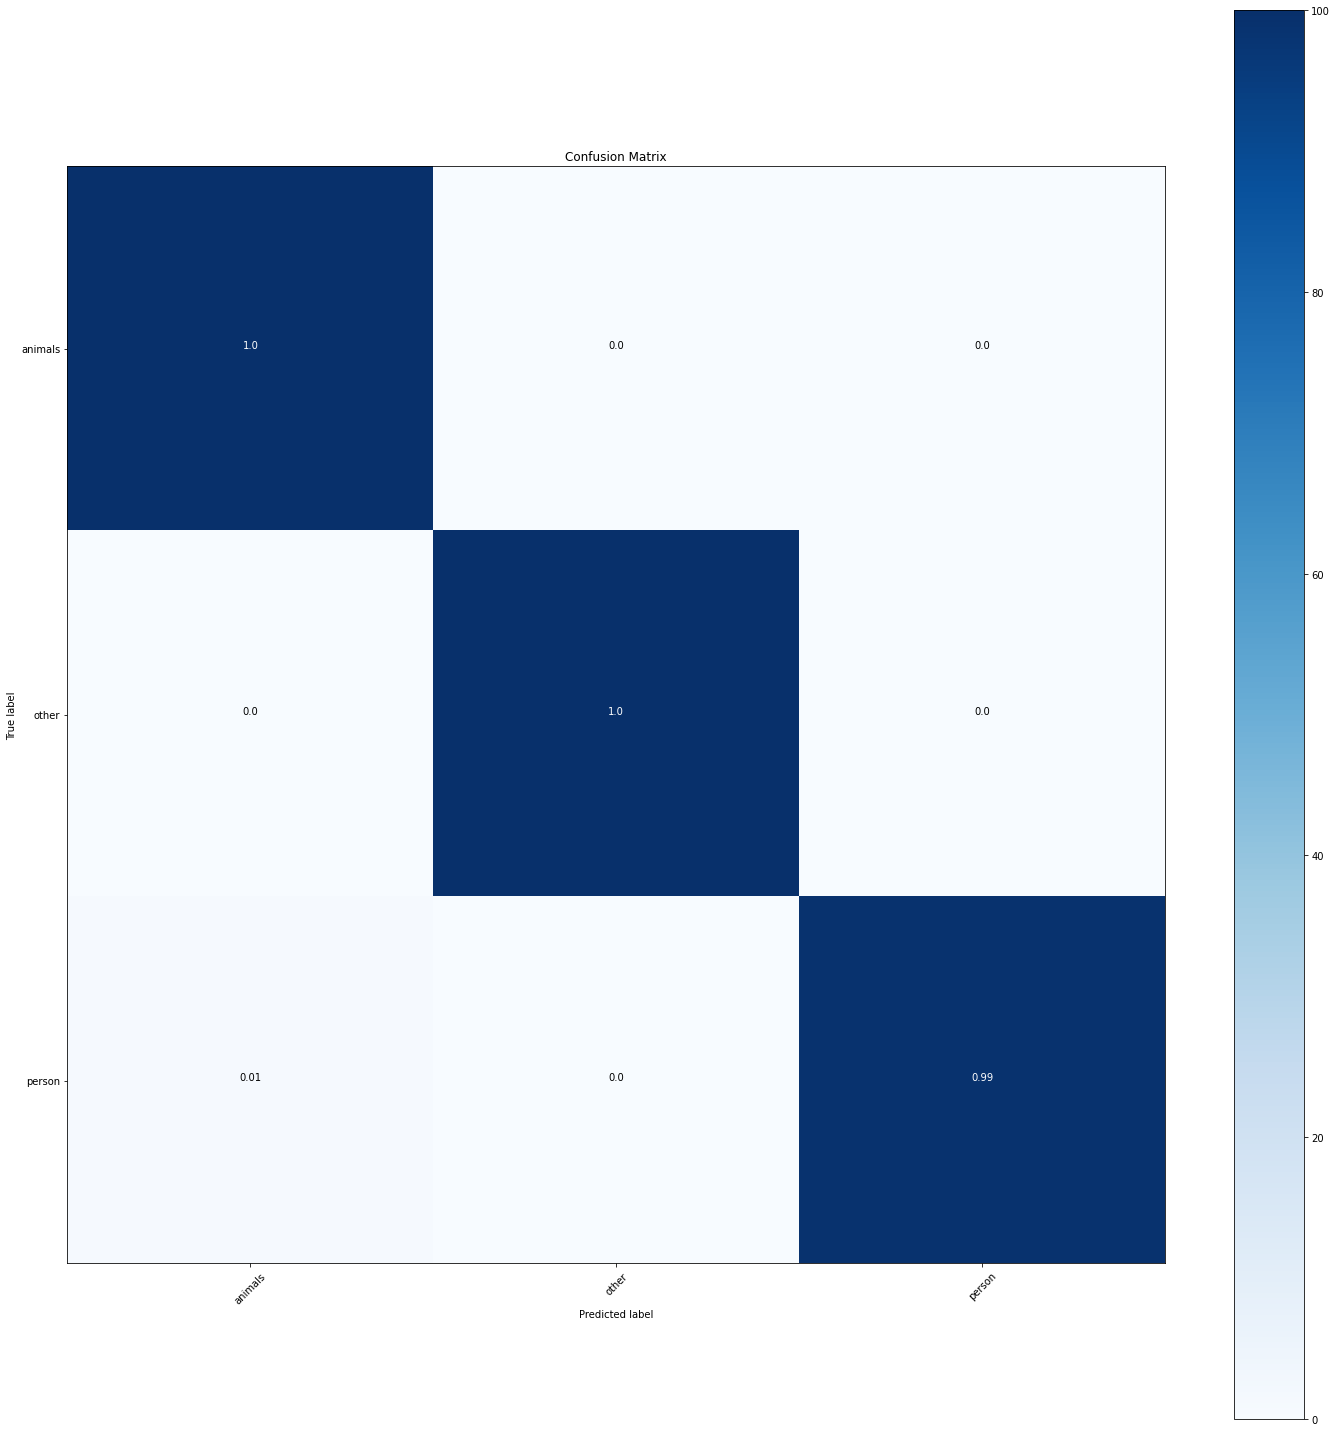

In [ ]:
#Plot the confusion matrix. Set Normalize = True/False

def plot_confusion_matrix(cm, classes, normalize=True, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(20,20))

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.around(cm, decimals=2)
        cm[np.isnan(cm)] = 0.0
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

#Print the Target names
from sklearn.metrics import classification_report, confusion_matrix
import itertools 
#shuffle=False

target_names = []
for key in train_generator.class_indices:
    target_names.append(key)

# print(target_names)

#Confution Matrix 

Y_pred = model.predict_generator(testing_generator)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
cm = confusion_matrix(testing_generator.classes, y_pred)
plot_confusion_matrix(cm, target_names, title='Confusion Matrix')

#Print Classification Report
print('Classification Report')
print(classification_report(testing_generator.classes, y_pred, target_names=target_names))

Visualize the history of network learning: accuracy, loss in graphs.




Text(0.5, 1.0, 'Accuracy Curves')

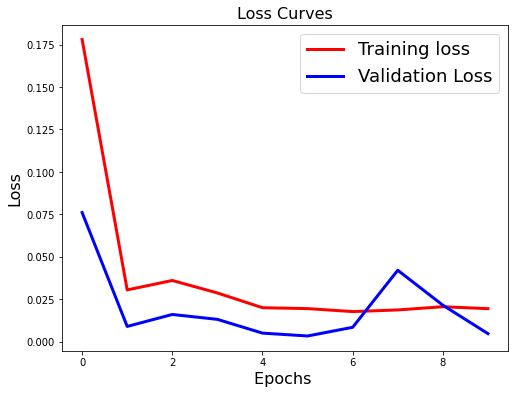

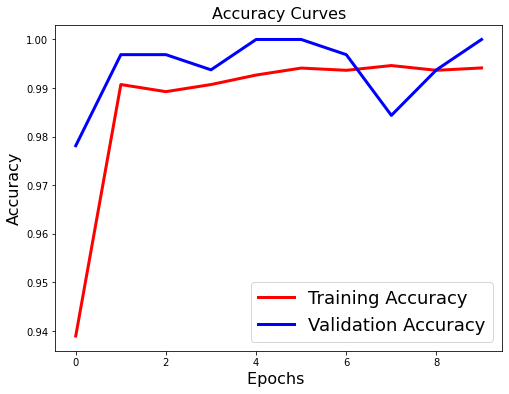

In [ ]:
#Plot the Graph

# Loss Curves
plt.figure(figsize=[8,6])
plt.plot(history.history['loss'],'r',linewidth=3.0)
plt.plot(history.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)
  
# Accuracy Curves
plt.figure(figsize=[8,6])
plt.plot(history.history['accuracy'],'r',linewidth=3.0)
plt.plot(history.history['val_accuracy'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)

# Fine tuning convolutional layers MobileNetV2 model

Download the best weights

In [ ]:
model.load_weights("inceptionv3_best.h5")

Defrost the last 2 blocks of MobileNetV2 model

> Блок с отступами



In [ ]:
pretrained_model.trainable = False
for layer in model.layers[:290]:
   layer.trainable = False
for layer in model.layers[290:]:
   layer.trainable = True


Compile a network with defrosted layers. And start learning

In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam', 
              metrics=["accuracy"])

filepath="inceptionv3_fine_tuned.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint, learning_rate_reduction]


steps_per_epoch = 32
history = model.fit_generator(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    validation_data=test_generator,
    validation_steps=5,
    callbacks=callbacks_list,
    epochs=10,
    verbose=1)

Epoch 1/10
32/32 [==============================] - ETA: 0s - loss: 0.0153 - accuracy: 0.9956
Epoch 00001: val_loss improved from inf to 0.01012, saving model to inceptionv3_fine_tuned.h5
32/32 [==============================] - 40s 1s/step - loss: 0.0153 - accuracy: 0.9956 - val_loss: 0.0101 - val_accuracy: 0.9969
Epoch 2/10
32/32 [==============================] - ETA: 0s - loss: 0.0176 - accuracy: 0.9941
Epoch 00002: val_loss improved from 0.01012 to 0.00894, saving model to inceptionv3_fine_tuned.h5
32/32 [==============================] - 39s 1s/step - loss: 0.0176 - accuracy: 0.9941 - val_loss: 0.0089 - val_accuracy: 0.9969
Epoch 3/10
32/32 [==============================] - ETA: 0s - loss: 0.0178 - accuracy: 0.9956
Epoch 00003: val_loss improved from 0.00894 to 0.00609, saving model to inceptionv3_fine_tuned.h5
32/32 [==============================] - 39s 1s/step - loss: 0.0178 - accuracy: 0.9956 - val_loss: 0.0061 - val_accuracy: 0.9969
Epoch 4/10
32/32 [=======================

Test Score

In [ ]:
test_score = model.evaluate_generator(testing_generator, batch_size)

print("[INFO] accuracy: {:.2f}%".format(test_score[1] * 100)) 
print("[INFO] Loss: ",test_score[0])

[INFO] accuracy: 100.00%
[INFO] Loss:  0.0037735644727945328


Visualize the history of network learning: accuracy, loss in graphs.




Text(0.5, 1.0, 'Accuracy Curves')

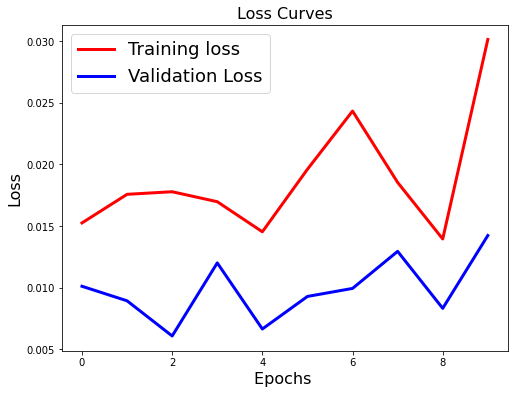

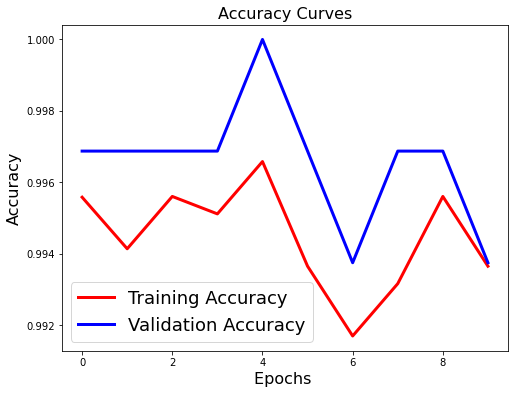

In [ ]:
#Plot the Graph

# Loss Curves
plt.figure(figsize=[8,6])
plt.plot(history.history['loss'],'r',linewidth=3.0)
plt.plot(history.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)
  
# Accuracy Curves
plt.figure(figsize=[8,6])
plt.plot(history.history['accuracy'],'r',linewidth=3.0)
plt.plot(history.history['val_accuracy'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)

Visualize the history of network learning for testing data in confusion matrix format

Confusion Matrix
Normalized confusion matrix
Classification Report
              precision    recall  f1-score   support

     animals       1.00      1.00      1.00       100
       other       1.00      1.00      1.00       100
      person       1.00      1.00      1.00       100

    accuracy                           1.00       300
   macro avg       1.00      1.00      1.00       300
weighted avg       1.00      1.00      1.00       300



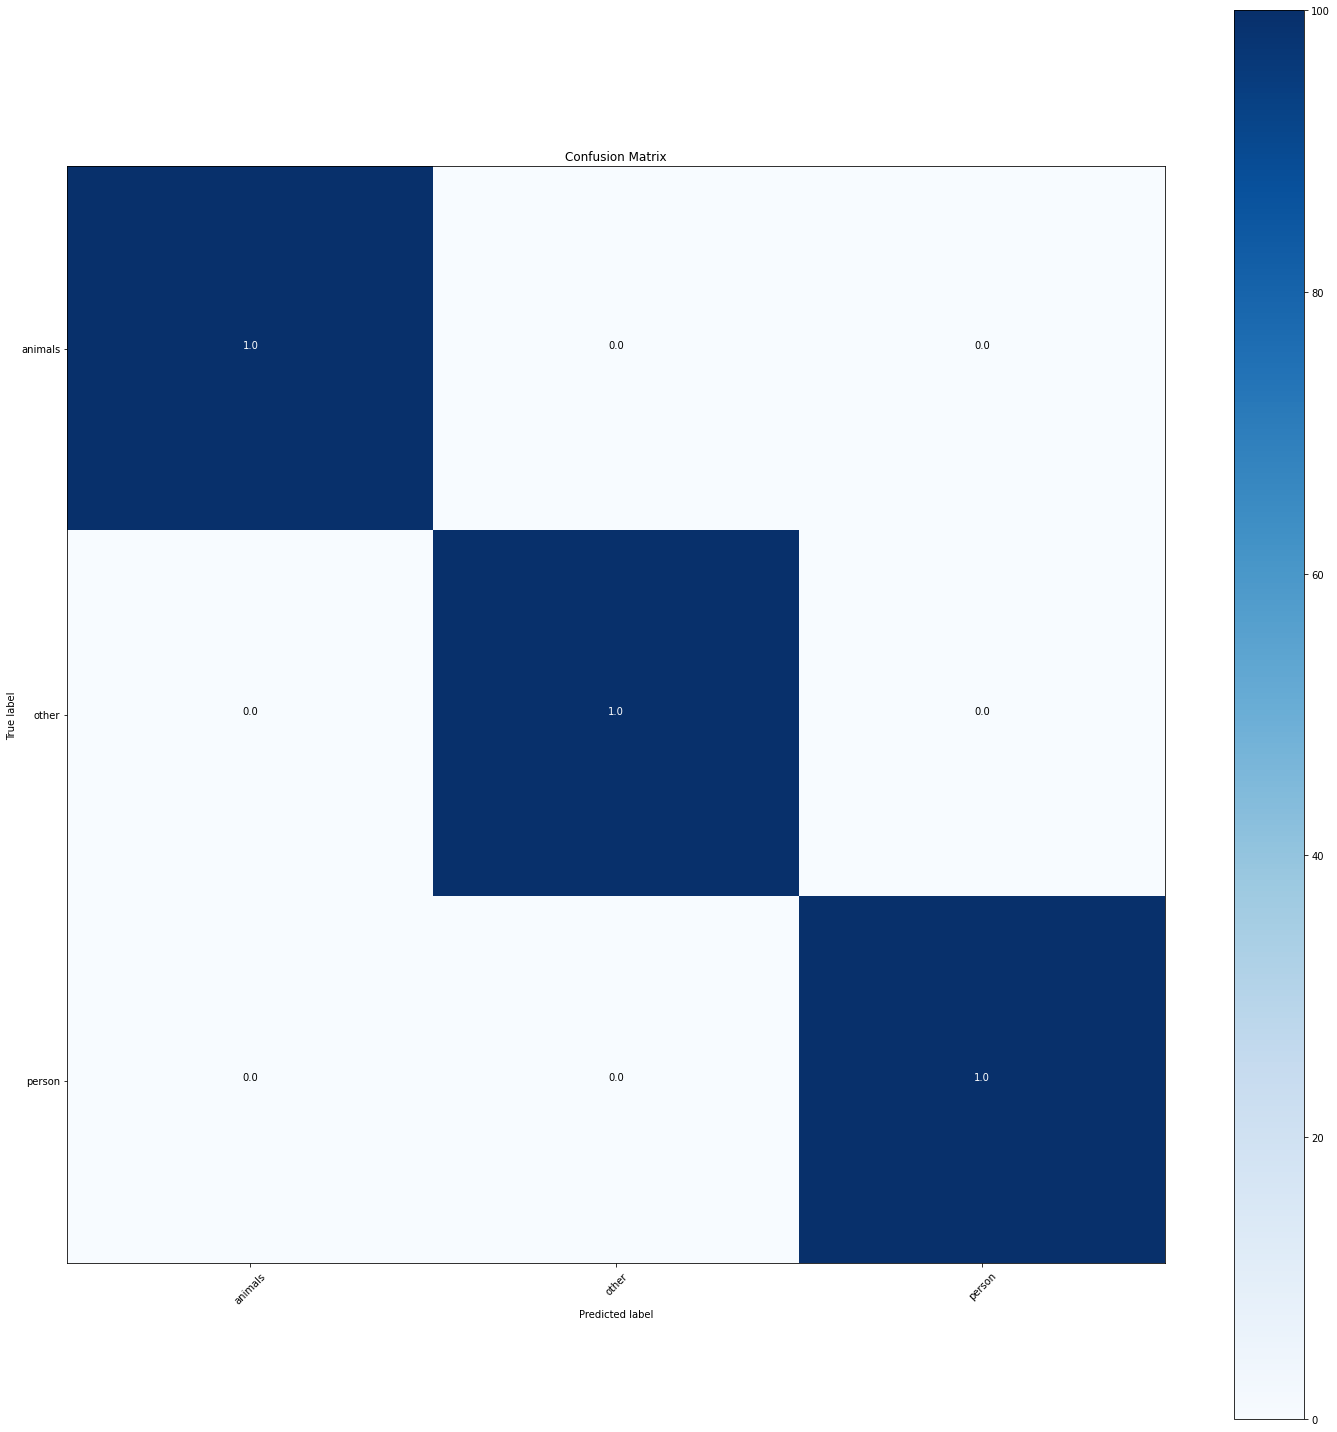

In [ ]:
#Plot the confusion matrix. Set Normalize = True/False

def plot_confusion_matrix(cm, classes, normalize=True, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(20,20))

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.around(cm, decimals=2)
        cm[np.isnan(cm)] = 0.0
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

#Print the Target names
from sklearn.metrics import classification_report, confusion_matrix
import itertools 
#shuffle=False

target_names = []
for key in train_generator.class_indices:
    target_names.append(key)

# print(target_names)

#Confution Matrix 

Y_pred = model.predict_generator(testing_generator)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
cm = confusion_matrix(testing_generator.classes, y_pred)
plot_confusion_matrix(cm, target_names, title='Confusion Matrix')

#Print Classification Report
print('Classification Report')
print(classification_report(testing_generator.classes, y_pred, target_names=target_names))